In [17]:
%matplotlib notebook
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from data_generator_breast import BreastPathQDataset
from data_generator_boneage import BoneAgeDataset
from data_generator_endovis import EndoVisDataset
from data_generator_oct import OCTDataset
from models import BreastPathQModel
from uce import uceloss
from calibration_plots import plot_uncert, plot_frequency
from utils import nll_criterion_gaussian
from glob import glob
%matplotlib notebook

In [18]:
base_model = 'densenet201'
data_set_name = 'endovis' # 'breastpathq', 'boneage', 'endovis', 'oct'

In [19]:
assert base_model in ['densenet201']
assert data_set_name in ['breastpathq', 'boneage', 'endovis', 'oct']
device = torch.device("cuda:0")
resize_to = (256, 256)

In [20]:
if data_set_name == 'breastpathq':
    in_channels = 3
    out_channels = 1
    batch_size = 16
    resize_to = (384, 384)

    data_set = BreastPathQDataset(data_dir='/media/fastdata/laves/breastpathq/', augment=False, resize_to=resize_to)
    assert len(data_set) > 0

    calib_indices = torch.load('./data_indices/breastpathq_valid_indices.pth')
    test_indices = torch.load('./data_indices/breastpathq_test_indices.pth')

    print(calib_indices.shape)
    print(test_indices.shape)

    calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                               sampler=SubsetRandomSampler(calib_indices))
    test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                              sampler=SubsetRandomSampler(test_indices))
elif data_set_name == 'boneage':
    in_channels = 1
    out_channels = 1
    batch_size = 16

    data_set = BoneAgeDataset(data_dir='/media/fastdata/laves/rsna-bone-age/', augment=False, resize_to=resize_to)
    assert len(data_set) > 0

    calib_indices = torch.load('./data_indices/boneage_valid_indices.pth')
    test_indices = torch.load('./data_indices/boneage_test_indices.pth')

    print(calib_indices.shape)
    print(test_indices.shape)

    calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                               sampler=SubsetRandomSampler(calib_indices))
    test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                              sampler=SubsetRandomSampler(test_indices))
elif data_set_name == 'endovis':
    in_channels = 3
    out_channels = 2
    batch_size = 16

    data_dir = '/media/fastdata/laves/EndoVis15_instrument_tracking'
    data_set_valid = EndoVisDataset(data_dir=data_dir+'/valid', augment=False, scale=0.5)
    data_set_test = EndoVisDataset(data_dir=data_dir+'/test', augment=False, scale=0.5)

    assert len(data_set_valid) > 0
    assert len(data_set_test) > 0
    print(len(data_set_valid))
    print(len(data_set_test))

    calib_loader = torch.utils.data.DataLoader(data_set_valid, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(data_set_test, batch_size=batch_size, shuffle=False)
elif data_set_name == 'oct':
    in_channels = 3
    out_channels = 6
    batch_size = 16
    resize_to = (256, 256)

    data_dir = '/media/fastdata/laves/oct_data_needle/data'
    data_set = OCTDataset(data_dir=data_dir, augment=False, resize_to=resize_to)
    assert len(data_set) > 0

    calib_indices = torch.load('./data_indices/oct_valid_indices.pth')
    test_indices = torch.load('./data_indices/oct_test_indices.pth')

    print(calib_indices.shape)
    print(test_indices.shape)

    calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                               sampler=SubsetRandomSampler(calib_indices))
    test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                              sampler=SubsetRandomSampler(test_indices))

2159
2232


In [21]:
num_ensembles = 3
ensembles = []

for i in range(num_ensembles):
    model = BreastPathQModel(base_model, in_channels=in_channels, out_channels=out_channels).to(device)

    checkpoint_path = glob(f"/media/fastdata/laves/regression_snapshots/{base_model}_gaussian_{data_set_name}_ensemble_{i}.pth.tar")[0]

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    print("Loading previous weights at epoch " + str(checkpoint['epoch']))
    model.eval()
    ensembles.append(model)

Loading previous weights at epoch 199
Loading previous weights at epoch 199
Loading previous weights at epoch 199


In [22]:
y_ps_test = []
vars_test = []
logvars_test = []
targets_test = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)

        y_ps = []
        logvars = []
        for net in ensembles:
            y_p, logvar, _ = net(data, dropout=False, mc_dropout=False)
            y_ps.append(y_p)
            logvars.append(logvar)

        y_ps = torch.stack(y_ps)
        var = y_ps.var(dim=0)
        logvars = torch.stack(logvars).mean(dim=0)

        y_ps_test.append(y_ps.detach())
        vars_test.append(var.detach())
        logvars_test.append(logvar.detach())
        targets_test.append(target.detach())

100%|██████████| 140/140 [01:06<00:00,  2.11it/s]


In [23]:
y_p_test = torch.cat(y_ps_test, dim=1).clamp(0, 1).permute(1,0,2)
mu_test = y_p_test.mean(dim=1)
var_test = torch.cat(vars_test, dim=0)
logvar_test = torch.cat(logvars_test, dim=0)
target_test = torch.cat(targets_test, dim=0)

In [24]:
err_test = (target_test-mu_test).pow(2).mean(dim=1, keepdim=True).sqrt()
errvar_test = (y_p_test-target_test.unsqueeze(1).repeat(1,num_ensembles,1)).pow(2).mean(dim=(1,2)).unsqueeze(-1)

uncertainty = 'total'

uncert_aleatoric_test = logvar_test.exp().mean(dim=1, keepdim=True)
uncert_epistemic_test = var_test.mean(dim=1, keepdim=True)

if uncertainty == 'aleatoric':
    uncert_test = uncert_aleatoric_test.sqrt().clamp(0, 1)
elif uncertainty == 'epistemic':
    uncert_test = uncert_epistemic_test.sqrt().clamp(0, 1)
else:
    uncert_test = (uncert_aleatoric_test + uncert_epistemic_test).sqrt().clamp(0, 1)

In [25]:
print((err_test**2).mean())
print(errvar_test.mean())
print((uncert_test**2).mean())
print(uncert_aleatoric_test.mean())
print(uncert_epistemic_test.mean())

err_test = errvar_test.sqrt()

tensor(0.0018, device='cuda:0')
tensor(0.0024, device='cuda:0')
tensor(0.0016, device='cuda:0')
tensor(0.0008, device='cuda:0')
tensor(0.0008, device='cuda:0')


In [26]:
print(nll_criterion_gaussian(mu_test, uncert_test.pow(2).log(), target_test).item())

-5.378011226654053


In [27]:
print(torch.nn.functional.mse_loss(uncert_test**2, err_test**2, reduction='sum').item())

0.03583833575248718


0.009865633212029934


<IPython.core.display.Javascript object>


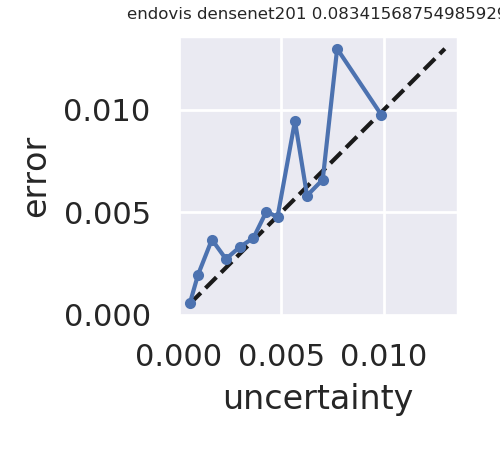

0.08341568754985929


In [28]:
if data_set_name == "breastpathq":
    uce_range = [0, 0.01]
elif data_set_name == "boneage":
    uce_range = [0, 0.01]
elif data_set_name == "endovis":
    uce_range = [0, 0.01]
elif data_set_name == "oct":
    uce_range = [0, 0.01]

print((uncert_test**2).max().item())

n_bins = 15
uce_uncal, _, _, _ = uceloss(err_test**2, uncert_test**2, n_bins=n_bins, )
_, err_uncal, sigma_uncal, _ = uceloss(err_test**2, uncert_test**2, n_bins=n_bins, range=uce_range)
fig, ax = plot_uncert(err_uncal.cpu(), sigma_uncal.cpu())
ax.set_title(data_set_name + " " + base_model + " " + str(uce_uncal.item()*100), size=6)
print(uce_uncal.item()*100)
fig.savefig(f"ensemble_{base_model}_{data_set_name}.pdf")

In [29]:
nll = nll_criterion_gaussian(mu_test, uncert_test, target_test).item()
print(nll)

0.03916516900062561
